In [ ]:
import sys
import copy
import json
import time
import math
import torch
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as TF
from torch import nn, optim, tensor
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

In [ ]:
from google.colab import drive

# TODO 0: Mount your Google Drive; this allows the runtime environment to access your drive.
drive.mount('/content/gdrive')

# NOTE: Make sure your path does NOT include a '/' at the end!
base_dir = "/content/gdrive/MyDrive/"
sys.path.append(base_dir)
## END TODO

Mounted at /content/gdrive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb 19 05:29:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# 1. Load Datasets

In [ ]:
with open('data/zh_embedding.pkl', 'rb') as file:
    zh_embedding = pickle.load(file)
    file.close()
with open('data/vocab_zh.pkl', 'rb') as file:
    vocab_zh = pickle.load(file)
    file.close()
with open('data/word_to_index_zh.pkl', 'rb') as file:
    word_to_index_zh = pickle.load(file)
    file.close()
with open('data/idx_to_embed_zh.pkl', 'rb') as file:
    idx_to_embed_zh = pickle.load(file)
    file.close()
with open('data/en_embedding.pkl', 'rb') as file:
    en_embedding = pickle.load(file)
    file.close()
with open('data/vocab_en.pkl', 'rb') as file:
    vocab_en = pickle.load(file)
    file.close()
with open('data/word_to_index_en.pkl', 'rb') as file:
    word_to_index_en = pickle.load(file)
    file.close()
with open('data/idx_to_embed_en.pkl', 'rb') as file:
    idx_to_embed_en = pickle.load(file)
    file.close()

In [ ]:
vocab_en = list(word_to_index_en.keys())
vocab_size_en = len(vocab_en)
first10pairs = {k: word_to_index_en[k] for k in list(word_to_index_en)[:10]}
print("The first 10 words in the English vocabulary are:", first10pairs)
print("EN vocab size is", vocab_size_en)
print("The index for the English word 'cannot' is:", word_to_index_en["cannot"])

The first 10 words in the English vocabulary are: {'and': 0, 'of': 1, 'a': 2, 'in': 3, 'is': 4, 'to': 5, 'for': 6, 'that': 7, 's': 8, 'with': 9}
EN vocab size is 82615
The index for the English word 'cannot' is: 700


In [ ]:
vocab_zh = list(word_to_index_zh.keys())
vocab_size_zh = len(vocab_zh)
first10pairs = {k: word_to_index_zh[k] for k in list(word_to_index_zh)[:10]}
print("The first 10 words in the Chinese vocabulary are:", first10pairs)
print("ZH vocab size is", vocab_size_zh)
print("The index for the Chinese word '的' is:", word_to_index_zh['的'])

The first 10 words in the Chinese vocabulary are: {'的': 0, '了': 1, '在': 2, '是': 3, '和': 4, '有': 5, '章': 6, '就': 7, '第': 8, '也': 9}
ZH vocab size is 95685
The index for the Chinese word '的' is: 0


skip

In [ ]:
# Define English inputs for the model
word_to_index_en = {}
idx_to_embed_en = {}
en_embedding = []
idx = 0
firstline = True
with open("gdrive/MyDrive/RelRep/data/cut-tencent-embeddings-en-d100.txt", 'r') as f:
    for line in f:
        if (firstline):
            firstline = False
            continue
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:], "float32")
        word_to_index_en[word] = idx
        idx_to_embed_en[idx] = embedding
        en_embedding.append(embedding)
        idx += 1
en_embedding = np.array(en_embedding)
vocab_en = list(word_to_index_en.keys())
vocab_size_en = len(vocab_en)
first10pairs = {k: word_to_index_en[k] for k in list(word_to_index_en)[:10]}
print("The first 10 words in the English vocabulary are:", first10pairs)
print("EN vocab size is", vocab_size_en)
print("The index for the English word 'cannot' is:", word_to_index_en["cannot"])

The first 10 words in the English vocabulary are: {'and': 0, 'of': 1, 'a': 2, 'in': 3, 'is': 4, 'to': 5, 'for': 6, 'that': 7, 's': 8, 'with': 9}
EN vocab size is 82615
The index for the English word 'cannot' is: 700


In [ ]:
# Define Chinese inputs for the model
word_to_index_zh = {}
idx_to_embed_zh = {}
zh_embedding = []
idx = 0
firstline = True
with open("gdrive/MyDrive/RelRep/data/cut-tencent-embeddings-zh-d100.txt", 'r') as f:
    for line in f:
        if (firstline):
            firstline = False
            continue
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:], "float32")
        word_to_index_zh[word] = idx
        idx_to_embed_zh[idx] = embedding
        zh_embedding.append(embedding)
        idx += 1
zh_embedding = np.array(zh_embedding)
vocab_zh = list(word_to_index_zh.keys())
vocab_size_zh = len(vocab_zh)
first10pairs = {k: word_to_index_zh[k] for k in list(word_to_index_zh)[:10]}
print("The first 10 words in the Chinese vocabulary are:", first10pairs)
print("ZH vocab size is", vocab_size_zh)
print("The index for the Chinese word '的' is:", word_to_index_zh['的'])

In [ ]:
# Load the golden set
with open('gdrive/MyDrive/RelRep/data/golden_set_FINAL.json', encoding="utf-8-sig") as in_file:
  # returns JSON object as a dictionary
    golden_set = json.load(in_file)

# Closing file
in_file.close()

first10pairs = {k: golden_set[k] for k in list(golden_set)[:10]}
print(first10pairs)

{'petard': ['作茧自缚', '以子之矛，攻子之盾', '吐丝自缚'], 'northeasterly': ['向东北的', '东北风'], 'relinquishment': ['放弃'], 'readers': ['读者'], 'thawed': ['融化'], 'improvised': ['自制', '即席'], 'webbed': ['有蹼的'], 'extolled': ['赞扬'], 'votive': ['奉献的', '还愿'], 'ardour': ['激情', '热忱']}


In [ ]:
# en_vocab_list is list of unique English words in golden set
gold_en_list = list(golden_set.keys())

# length of English vocabulary
gold_en_size = len(gold_en_list)
print("There are", gold_en_size, "unique English words in our golden set")

There are 46409 unique English words in our golden set


In [ ]:
# Load the partitioned golden set
with open('gdrive/MyDrive/RelRep/data/partitioned_golden_set2.json', encoding="utf-8-sig") as in_file:
  # returns JSON object as a dictionary
    partitioned_golden_set = json.load(in_file)

# Closing file
in_file.close()

concrete_emotion_label = partitioned_golden_set['concrete']['emotion_label']
concrete_emotion_laden = partitioned_golden_set['concrete']['emotion_laden']
concrete_other = partitioned_golden_set['concrete']['other']
abstract_emotion_label = partitioned_golden_set['abstract']['emotion_label']
abstract_emotion_laden = partitioned_golden_set['abstract']['emotion_laden']
abstract_other = partitioned_golden_set['abstract']['other']
unknown_emotion_label = partitioned_golden_set['unknown_abstraction']['emotion_label']
unknown_emotion_laden = partitioned_golden_set['unknown_abstraction']['emotion_laden']
unknown_other = partitioned_golden_set['unknown_abstraction']['other']

In [ ]:
# Load the lemmatized golden set
with open('gdrive/MyDrive/RelRep/data/lemmatized_golden_set.json', encoding="utf-8-sig") as in_file:
  # returns JSON object as a dictionary
    lemmatized_golden_set = json.load(in_file)

# Closing file
in_file.close()

# sanity check
lemma_en_list = list(lemmatized_golden_set.keys())
lemma_en_size = len(lemma_en_list)
print("There are", lemma_en_size, "unique English words in our lemmatized golden set")
assert lemma_en_size == len(concrete) + len(abstract) + len(emotion_label) + len(emotion_laden) + len(other)

There are 37888 unique English words in our lemmatized golden set


In [ ]:
# read swadesh list
swadesh = list(set(open("gdrive/MyDrive/RelRep/data/swadesh.txt", "r", encoding='utf-8-sig').read().split()))
swadesh = [x.lower() for x in swadesh]
print("There are", len(swadesh), "swadesh words with duplicates removed")

There are 204 swadesh words with duplicates removed


# 2. Preprocess

In [ ]:
torch.manual_seed(4)
np.random.seed(4)
random.seed(4)

In [ ]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd

In [ ]:
def preprocess():
  """
  1) To be in the training data, the translation pairs in the
  golden set must be in the Tencent dataset.
  2) Preprocess the English words s.t. they are stemmed and
  lemmatized
  """
  data     = {}
  en       = [] # list of indices for English words in Tecent dataset
  zh       = [] # list of indices for Chinese words in Tecent dataset
  en_list  = []
  zh_list  = []
  en_index = [] # [(apple, 12), (banana, 13)]
  zh_index = [] # [(苹果, 52), (香蕉, 23)]

  # Make copies of English words that have more than 1 Chinese translation
  for en in gold_en_list:
    for zh in golden_set[en]:
      en_list.append(en)
      zh_list.append(zh)

  # The real training data are the words that exist in the Tencent AI dataset
  en = [word_to_index_en[i] for i, j in zip(en_list, zh_list) if i in word_to_index_en and j in word_to_index_zh]
  zh = [word_to_index_zh[i] for i, j in zip(zh_list, en_list) if i in word_to_index_zh and j in word_to_index_en]
  en_index = [(i, word_to_index_en[i]) for i, j in zip(en_list, zh_list) if i in word_to_index_en and j in word_to_index_zh]
  zh_index = [(i, word_to_index_zh[i]) for i, j in zip(zh_list, en_list) if i in word_to_index_zh and j in word_to_index_en]

  data["en_index"]  = en_index
  data["zh_index"] = zh_index

  return en, zh, data

en_index, zh_index, en_zh_index = preprocess()
print("Translation for {} is {}".format(en_zh_index["en_index"][1099][0], en_zh_index["zh_index"][1099][0]))
print("There are {} training data after preprocessing".format(len(en_zh_index["en_index"])))

Translation for abandoning is 放弃
There are 55872 training data after preprocessing


# 3. Scheduler

In [ ]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

# 4. Custom Dataset

In [ ]:
# Define dataset to load to dataloader
class TrainData(Dataset):

    def __init__(self, trained_data):
        """Loads the data from the pretrained model"""
        self.data = trained_data

    def __getitem__(self, idx):
        """Returns the datapoint at a given index"""
        return self.data[idx]

    def __len__(self):
        """Returns the number of datapoints in the dataset"""
        return len(self.data)

In [ ]:
# Define collate_batch for batch of training samples

def wordToindex(word):
    """Get the corresponding index for the Chinese word"""
    return word_to_index_zh[word]

def collate_batch(batch):
    """Converts a batch of data into packed PyTorch tensor format,
    and collates the results by index, word, and one-hot vector
    for use in an Autoencoder.
    """
    # Initialize lists that separate out the 3 components
    index_list      = list()
    word_list       = list()

    for word in batch:
        # Convert to PyTorch format
        index   = wordToindex(word)

        # Add converted data to separate component lists
        index_list.append(index)
        word_list.append(word)

    # Convert to mini-batch tensors
    index_tensor = torch.tensor(index_list, dtype=torch.int64)

    return (word_list, index_tensor)

# 5. Create latent spaces + relative embeddings

In [ ]:
from typing import *
!pip install pytorch_lightning
from pytorch_lightning import seed_everything
from tqdm.auto import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 21.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-man

In [ ]:
"""
This code is adopted from Moschella et al's work: https://github.com/lucmos/relreps?tab=readme-ov-file
"""
def relative_projection(x: torch.Tensor, anchors: torch.Tensor) -> torch.Tensor:
    """Compute the relative representation of x with the cosine similarity

    Args:
        x: the samples absolute latents [batch, hidden_dim]
        anchors: the anchors absolute latents [anchors, hidden_dim]

    Returns:
        the relative representation of x. The relative representation is *not* normalized,
        when training on relative representation it is useful to normalize it
    """
    x = TF.normalize(x, p=2, dim=-1)
    anchors = TF.normalize(anchors, p=2, dim=-1)
    return torch.einsum("bm, am -> ba", x, anchors)

class LatentSpace:
    def __init__(
        self,
        encoding_type: str,
        encoder_name: str,
        vectors: torch.Tensor,
        ids: Sequence[int],
    ):
        """Utility class to represent a generic latent space

        Args:
            encoding_type: the type of latent space, i.e. "absolute" or "relative" usually
            encoder_name: the name of the encoder used to obtain the vectors
            vectors: the latents that compose the latent space
            ids: the ids associated with the vectors
        """
        assert vectors.shape[0] == len(ids)

        self.encoding_type: str = encoding_type
        self.vectors: torch.Tensor = vectors
        self.ids: Sequence[int] = ids
        self.encoder_name: str = encoder_name

    def get_anchors(self, anchor_choice: str, num_anchors: int, seed: int) -> Sequence[int]:
        """Adopt some strategy to select the anchors.

        Args:
            anchor_choice: the selection strategy for the anchors
            seed: the random seed to use

        Returns:
            the ids of the chosen anchors
        """
        # Select anchors
        seed_everything(seed)
        anchor_set = []
        if anchor_choice == "uniform":
            while (len(anchor_set) != num_anchors):
              anchor_id = random.randint(0, len(self.ids))

              if anchor_id in anchor_set:
                # if the selected anchor is already in the set, pass
                continue
              elif anchor_id in en_index and anchor_id in zh_index:
                # if the selected anchor is in training set include it
                anchor_set.append(anchor_id)
              else:
                continue
        elif anchor_choice == "swadesh":
            for word in swadesh:
                anchor_id = word_to_index_en[word]
                anchor_set.append(anchor_id)
        else:
            assert NotImplementedError

        result = sorted(anchor_set)
        return result

    def to_relative(
        self, anchor_choice: str = None, seed: int = None, anchors: Optional[Sequence[int]] = None
    ) -> "RelativeSpace":
        """Compute the relative transformation on the current space returning a new one.

        Args:
            anchor_choice: the anchors selection strategy to use, if no anchors are provided
            seed: the random seed to use
            anchors: the ids of the anchors to use

        Returns:
            the RelativeSpace associated to the current LatentSpace
        """
        assert self.encoding_type != "relative"  # TODO: for now
        anchors = self.get_anchors(anchor_choice=anchor_choice, seed=seed) if anchors is None else anchors

        anchor_latents: torch.Tensor = self.vectors[anchors]

        relative_vectors = relative_projection(x=self.vectors, anchors=anchor_latents.cpu())

        return RelativeSpace(vectors=relative_vectors, encoder_name=self.encoder_name, anchors=anchors, ids=self.ids)

class RelativeSpace(LatentSpace):
    def __init__(
        self,
        vectors: torch.Tensor,
        ids: Sequence[int],
        anchors: Sequence[int],
        encoder_name: str = None,
    ):
        """Utility class to represent a relative latent space

        Args:
            vectors: the latents that compose the latent space
            ids: the ids associated ot the vectors
            encoder_name: the name of the encoder_name used to obtain the vectors
            anchors: the ids associated to the anchors to use
        """
        super().__init__(encoding_type="relative", vectors=vectors, encoder_name=encoder_name, ids=ids)
        self.anchors: Sequence[int] = anchors

# 6. Create latent space and relative embeddings using chosen anchors

In [ ]:
# Read dictionary to memory
def read_anchors(filePath):
    # for reading also binary mode is important
    with open(filePath, 'rb') as fp:
        n_list = json.load(fp)
        return n_list

r_anchors = read_anchors("data/anchors_random_dim_200.json")
print('Chosen English anchors are', r_anchors["en"])
print('Chosen Chinese anchors are', r_anchors["zh"])

Chosen English anchors are [3, 7, 17, 20, 30, 39, 40, 45, 70, 83, 95, 100, 105, 109, 119, 137, 163, 176, 195, 214, 218, 234, 235, 247, 266, 272, 303, 329, 339, 437, 465, 489, 498, 507, 510, 525, 542, 571, 607, 657, 660, 716, 726, 727, 734, 751, 769, 784, 902, 938, 998, 1004, 1016, 1025, 1099, 1148, 1301, 1315, 1321, 1388, 1503, 1524, 1529, 1607, 1641, 1706, 1738, 1816, 1845, 1858, 1934, 1963, 2021, 2037, 2063, 2142, 2178, 2181, 2203, 2264, 2292, 2442, 2540, 2588, 2643, 2649, 2674, 2713, 2862, 2931, 2949, 2973, 2994, 3051, 3076, 3180, 3194, 3297, 3343, 3377, 3483, 3515, 3538, 3539, 3588, 3695, 3717, 3735, 3757, 3854, 3927, 4078, 4167, 4178, 4183, 4312, 4337, 4391, 4406, 4516, 4821, 4824, 4829, 5096, 5138, 5240, 5268, 5373, 5412, 5441, 5450, 5482, 5739, 5880, 5908, 6062, 6101, 6222, 6329, 6396, 6427, 6642, 6687, 6785, 6805, 6823, 6928, 6971, 7231, 7299, 7366, 7745, 7900, 7918, 8374, 8526, 8579, 8624, 8805, 8871, 8901, 9418, 9635, 9830, 9946, 10210, 10510, 10523, 10687, 10699, 11503, 1159

In [ ]:
# Double check number of anchors are equal in English and Chinese
assert len(r_anchors["en"]) == len(r_anchors["zh"])
NUM_ANCHORS = len(r_anchors["en"])
print("Number of anchors =", NUM_ANCHORS)

In [ ]:
NUM_SAMPLES_EN = vocab_size_en

en_anchors_ids = r_anchors["en"]
print("Selected English anchor ids are:", en_anchors_ids)

# Create English latent space from English absolute embeddings
en_abs_embedding = torch.FloatTensor(en_embedding)

en_abs_latent_space = LatentSpace(
    encoding_type="absolute",
    encoder_name="english abs embedding",
    vectors=en_abs_embedding,
    ids=list(range(NUM_SAMPLES_EN)),
)
print("En absolute embedding shape", en_abs_latent_space.vectors.shape)

en_rel_latent_space = en_abs_latent_space.to_relative(anchors=en_anchors_ids)
print("En relative embedding shape", en_rel_latent_space.vectors.shape)

In [ ]:
NUM_SAMPLES_ZH = vocab_size_zh

zh_anchors_ids = r_anchors["zh"]
print("Corresponding Chinese anchor ids are:", zh_anchors_ids)

zh_abs_embedding = torch.FloatTensor(zh_embedding)

zh_abs_latent_space = LatentSpace(
    encoding_type="absolute",
    encoder_name="chinese abs embedding",
    vectors=zh_abs_embedding,
    ids=list(range(NUM_SAMPLES_ZH)),
)

# The shape is [num_samples, hidden_dim]
print("Zh absolute embedding shape", zh_abs_latent_space.vectors.shape)

# Transform Chinese absolute latent space to relative latent space using the anchors chosen
zh_rel_latent_space = zh_abs_latent_space.to_relative(anchors=zh_anchors_ids)
print("Zh relative embedding shape", zh_rel_latent_space.vectors.shape)

Corresponding Chinese anchor ids are: [27, 117, 181, 241, 305, 369, 405, 663, 672, 697, 714, 765, 879, 950, 968, 1229, 1301, 1360, 1431, 1437, 1560, 1716, 1766, 1847, 1889, 1903, 2014, 2186, 2253, 2325, 2335, 2816, 2821, 2884, 2934, 2951, 2976, 3032, 3033, 3124, 3165, 3366, 3377, 3411, 3514, 3585, 3590, 3702, 3768, 3852, 3915, 3915, 3968, 4130, 4228, 4327, 4353, 4435, 4449, 4452, 4595, 4608, 4627, 4894, 5094, 5119, 5144, 5399, 5476, 5620, 5794, 5823, 5825, 5840, 6140, 6536, 6928, 7430, 7522, 7531, 7594, 7745, 7853, 7937, 8008, 8453, 8831, 9040, 9131, 9455, 9635, 10487, 10721, 10869, 11032, 11099, 11383, 11720, 11770, 11931, 12013, 12353, 12827, 13065, 13414, 13585, 14010, 14179, 14331, 14684, 14705, 14791, 14897, 14939, 15402, 16276, 16460, 17304, 17551, 17672, 17821, 17834, 18048, 18203, 18248, 18597, 18718, 18732, 18990, 19036, 19276, 19458, 19562, 19568, 19789, 19999, 20080, 20410, 20810, 20946, 21730, 21744, 22370, 22502, 22531, 23188, 23312, 23944, 25036, 25263, 25420, 25441, 2587

# 7. Model Definition

In [ ]:
class ZhZhAutoencoderTW(nn.Module):
    """
    Autoencoder to learn the weights connecting Chinese
    embeddings back to one-hot vectors. Initialize the
    weights connecting the embeddings and one-hot vectors
    with the transpose of the weights from the Tecent
    pretrained model, connecting the one-hot vector and
    embedding, to speed up training.
    """
    def __init__(self, pretrained):
        super(ZhZhAutoencoderTW, self).__init__()

        # Save the pretrained embedding within the model
        # load pretrained embeddings and freeze them
        self.weights    = torch.FloatTensor(pretrained.vectors)
        self.encoder    = nn.Embedding.from_pretrained(self.weights, freeze = True)

        # Make a copy of the pretrained weights and use them in the following layers
        copy_pretrained = copy.deepcopy(pretrained)
        self.copyweight = torch.FloatTensor(copy_pretrained.vectors)
        self.decoder    = nn.Parameter(self.copyweight.t())

    def forward(self, text):
        """The pipeline that takes input values through the network"""
        # Find the embeddings for text
        trained_embed = self.encoder(text)

        # Turn embedding back to one-hot
        one_hot       = trained_embed @ self.decoder

        return one_hot

# 9. Train

In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
def train(model,
          train_history,
          modelFilePath,
          num_epochs,
          optimizer,
          criterion,
          batch_size,
          train_loader,
          base_lr,
          final_lr):
  avg_loss = []
  start = time.time()
  scheduler = CosineScheduler(max_update=num_epochs, base_lr=base_lr, final_lr=final_lr)
  print("\n-----Batch Size =", batch_size, "NUM_ANCHORS =", NUM_ANCHORS, file=open(train_history, 'a'))

  for epoch in range(num_epochs):
    losses = 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    print('\nEpoch: %d \nPercent Finished: %d%% Time Elapsed: %s' % (epoch, epoch / num_epochs * 100, timeSince(start)), file=open(train_history, 'a'))
    for batch_idx, (word, index) in loop:
      # Clear gradients w.r.t. parameters
      optimizer.zero_grad()

      index = index.to(device)

      # Forward pass to get output/logits
      outputs_train = model(index)

      # Calculate Loss: softmax --> cross entropy loss
      loss = criterion(outputs_train, index)
      losses += loss.item()

      # Getting gradients w.r.t. parameters
      loss.backward()

      # Updating parameters
      optimizer.step()

      # update progress bar
      loop.set_description(f"Epoch: [{epoch}/{num_epochs}]")
      loop.set_postfix(loss=loss.item())

    avg = losses / vocab_size_zh
    avg_loss.append(avg)

    for param_group in optimizer.param_groups:
        param_group['lr'] = scheduler(epoch)
        print("Learning rate is now", param_group['lr'], file=open(train_history, 'a'))

    print("   Loss: {:.15f}".format(avg), file=open(train_history, 'a'))
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
        'learning_rate': param_group['lr']
        }, modelFilePath)

  print("Finish training!", file=open(train_history, 'a'))
  return avg_loss

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
zhzhmodel = ZhZhAutoencoderTW(zh_rel_latent_space).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(zhzhmodel.parameters(), lr=0.01)

In [ ]:
BATCH_SIZE = 4096

training_data = TrainData(vocab_zh)
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           collate_fn=collate_batch)

In [ ]:
NUM_EPOCH = 100

new_loss = train(zhzhmodel,
            'gdrive/MyDrive/RelRep/record/zhrelabs.txt',
            'gdrive/MyDrive/RelRep/ckpt/zh_rel_to_abs_random_a200_e100-200_TEST.pt',
            NUM_EPOCH,
            optimizer,
            criterion,
            BATCH_SIZE,
            train_loader,
            base_lr=0.001,
            final_lr=0.0001)
loss.extend(new_loss)
# save the losses in the pickle file
import pickle
with open('gdrive/MyDrive/RelRep/record/zh_reltoabs_loss_random_a200_TEST.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(loss, file)

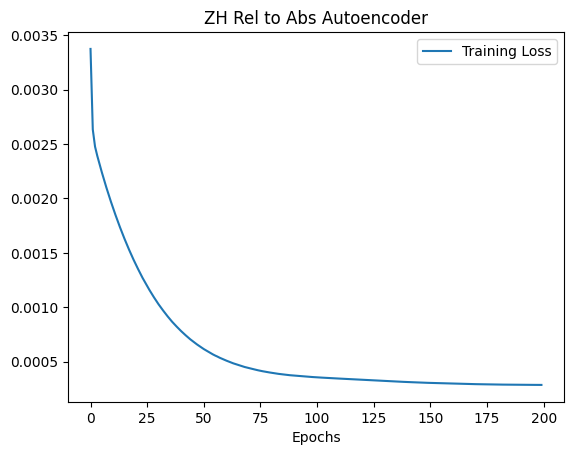

In [ ]:
xtrain = np.arange(200)
plt.plot(xtrain, loss, label = "Training Loss")
plt.xlabel("Epochs")
plt.title("ZH Rel to Abs Autoencoder")
plt.legend()

# 11. Test

In [ ]:
state = torch.load('gdrive/MyDrive/RelRep/ckpt/zh_rel_to_abs_random_a200_e0-100_TEST.pt')
zhzhmodel.load_state_dict(state['model_state_dict'])
optimizer.load_state_dict(state['optimizer_state_dict'])

In [ ]:
# Get a single sample
BATCH_SIZE = 1

train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           collate_fn=collate_batch)

In [ ]:
test = next(iter(train_loader))
print("Random word:", test[0])
pos = torch.argmax(zhzhmodel(test[1].to(device)))
print("Model prediction:", vocab_zh[pos])

Random word: ['特洛伊']
Model prediction: 特洛伊
